In [1]:
!pip install numpy matplotlib tensorflow keras opencv-python


In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [16]:
def load_images_and_labels(base_path, label_path):
    images = []
    labels = []
    label_data = {}

    # Load labels from the text file
    with open(label_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line in lines[1:]:  # Skip header line
            parts = line.split('||')
            if len(parts) > 3:
                image_id = parts[1].strip()  # Image ID is in the second column
                diagnosis = parts[3].strip()  # Clinical Diagnosis is in the fourth column
                if diagnosis.isdigit():
                    label = int(diagnosis)
                    label_data[image_id] = label

    # Load images and assign labels
    for folder in os.listdir(base_path):
        if folder.startswith("IMD"):
            image_path = os.path.join(base_path, folder, folder + "_Dermoscopic_Image", folder + ".bmp")
            if folder in label_data:  # Only load images with valid labels
                image = cv2.imread(image_path)
                image = cv2.resize(image, (200, 200))  # Resize to match model input
                images.append(image)
                labels.append(label_data[folder])
            else:
                print(f"No label found for: {folder}")

    return np.array(images), np.array(labels)

base_path = 'C:/Users/KUN/Desktop/jhu course/Medical image analysis/project/project1/archive/PH2Dataset/PH2 Dataset images'
label_path = 'C:/Users/KUN/Desktop/jhu course/Medical image analysis/project/project1/archive/PH2Dataset/PH2_dataset.txt'
images, labels = load_images_and_labels(base_path, label_path)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [20]:
print("Unique labels in dataset:", np.unique(labels))


Unique labels in dataset: [0 1 2]


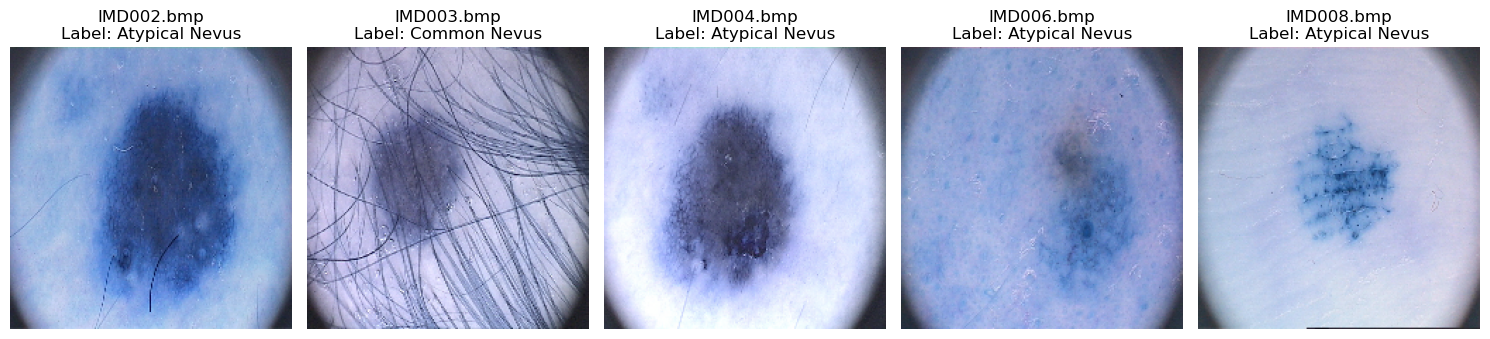

In [31]:
import matplotlib.pyplot as plt
import os

def plot_images_with_names(image_paths, images, labels, classes, num_images=5):
    # Create a grid with 'num_images' number of images along with their labels and names.
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    axes = axes.flatten()
    for path, img, lbl, ax in zip(image_paths[:num_images], images[:num_images], labels[:num_images], axes):
        ax.imshow(img)
        ax.axis('off')
        # Extract the image name from the path
        image_name = os.path.basename(path)
        ax.set_title(f'{image_name}\nLabel: {classes[lbl]}')
    plt.tight_layout()
    plt.show()

# Assuming 'images' and 'labels' are your datasets and 'classes' is a list of class names
# Assuming 'image_paths' is a list of paths corresponding to each image
classes = ['Common Nevus', 'Atypical Nevus', 'Melanoma']
image_paths = [os.path.join(base_path, folder, folder + "_Dermoscopic_Image", folder + ".bmp") for folder in os.listdir(base_path)]
plot_images_with_names(image_paths, images, labels, classes)


In [36]:
from tensorflow.keras.layers import Input

# Redefine the model
model = Sequential([
    Input(shape=(200, 200, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dropout(rate=0.5),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(rate=0.5),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dropout(rate=0.5),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(units=3, activation='softmax', kernel_initializer='glorot_uniform', name='classifier')  # Assuming 3 classes
])



In [37]:
# Continue as previously shown to compile and train the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [38]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)


In [39]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[reduce_lr]
)


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 848ms/step - accuracy: 0.4694 - loss: 1.2401 - val_accuracy: 0.4500 - val_loss: 54.3505 - learning_rate: 0.0010
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 816ms/step - accuracy: 0.4806 - loss: 1.1505 - val_accuracy: 0.4500 - val_loss: 58.1237 - learning_rate: 0.0010
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step - accuracy: 0.5210 - loss: 1.1752 - val_accuracy: 0.4500 - val_loss: 47.5684 - learning_rate: 0.0010
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 800ms/step - accuracy: 0.4410 - loss: 1.1406 - val_accuracy: 0.4500 - val_loss: 28.8236 - learning_rate: 0.0010
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 807ms/step - accuracy: 0.5821 - loss: 0.9489 - val_accuracy: 0.4500 - val_loss: 20.1859 - learning_rate: 0.0010
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 790ms/step - accuracy: 0.5929 - loss: 0.8813 - val_accuracy: 0.4500 - val_loss: 17.6961 - learning_rate: 0.0010
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 807ms/step - accuracy: 0.6135 - loss: 0.8796 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 885ms/step - accuracy: 0.9394 - loss: 0.2787 - val_accuracy: 0.4250 - val_loss: 1.4246 - learning_rate: 1.0000e-05
Epoch 88/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 887ms/step - accuracy: 0.9392 - loss: 0.2848 - val_accuracy: 0.4250 - val_loss: 1.4282 - learning_rate: 1.0000e-05
Epoch 89/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 832ms/step - accuracy: 0.9390 - loss: 0.2489 - val_accuracy: 0.4250 - val_loss: 1.4303 - learning_rate: 1.0000e-05
Epoch 90/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 915ms/step - accuracy: 0.9208 - loss: 0.2580 - val_accuracy: 0.4250 - val_loss: 1.4313 - learning_rate: 1.0000e-05
Epoch 91/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 920ms/step - accuracy: 0.9767 - loss: 0.2159 - val_accuracy: 0.4250 - val_loss: 1.4307 - learning_rate: 1.0000e-05
Epoch 92/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 928ms/step - accuracy: 0.9360 - loss: 0.2739 - val_accuracy: 0.4250 - val_loss: 1.4303 - learning_rate: 1.0000e-05
Epoch 93/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 838ms/step - accuracy: 0.9525 - loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 820ms/step - accuracy: 0.9719 - loss: 0.2578 - val_accuracy: 0.4500 - val_loss: 1.4667 - learning_rate: 1.0000e-05
Epoch 131/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 866ms/step - accuracy: 0.9431 - loss: 0.2812 - val_accuracy: 0.4500 - val_loss: 1.4659 - learning_rate: 1.0000e-05
Epoch 132/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 818ms/step - accuracy: 0.9762 - loss: 0.2083 - val_accuracy: 0.4500 - val_loss: 1.4651 - learning_rate: 1.0000e-05
Epoch 133/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 834ms/step - accuracy: 0.9467 - loss: 0.2361 - val_accuracy: 0.4500 - val_loss: 1.4676 - learning_rate: 1.0000e-05
Epoch 134/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 837ms/step - accuracy: 0.9242 - loss: 0.2632 - val_accuracy: 0.4500 - val_loss: 1.4705 - learning_rate: 1.0000e-05
Epoch 135/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 863ms/step - accuracy: 0.9271 - loss: 0.2672 - val_accuracy: 0.4500 - val_loss: 1.4702 - learning_rate: 1.0000e-05
Epoch 136/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 872ms/step - accuracy: 0.9327 

Epoch 173/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 836ms/step - accuracy: 0.9819 - loss: 0.1806 - val_accuracy: 0.4500 - val_loss: 1.4758 - learning_rate: 1.0000e-05
Epoch 174/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step - accuracy: 0.9498 - loss: 0.1934 - val_accuracy: 0.4500 - val_loss: 1.4781 - learning_rate: 1.0000e-05
Epoch 175/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step - accuracy: 0.9446 - loss: 0.1928 - val_accuracy: 0.4750 - val_loss: 1.4771 - learning_rate: 1.0000e-05
Epoch 176/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 815ms/step - accuracy: 0.9467 - loss: 0.2204 - val_accuracy: 0.4250 - val_loss: 1.4761 - learning_rate: 1.0000e-05
Epoch 177/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 787ms/step - accuracy: 0.9485 - loss: 0.2287 - val_accuracy: 0.4250 - val_loss: 1.4796 - learning_rate: 1.0000e-05
Epoch 178/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 806ms/step - accuracy: 0.9571 - loss: 0.2254 - val_accuracy: 0.4250 - val_loss: 1.4830 - learning_rate: 1.0000e-05
Epoch 179/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 796ms/step - acc

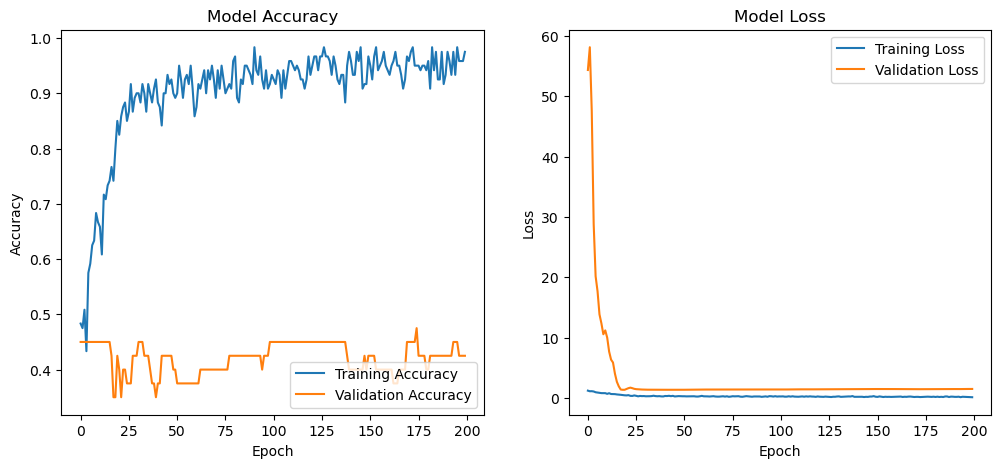

In [52]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()



In [42]:
import numpy as np
import os
import cv2

def load_and_preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (200, 200))  # Assuming the input size of the model is 200x200
    image = np.array(image) / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Assuming model is already loaded and compiled
base_path = 'C:/Users/KUN/Desktop/jhu course/Medical image analysis/project/project1/MedIA_skin_test_dataset/test_dataset'

# Loop over the range of test images
for i in range(1, 51):  # Loop from Test01 to Test50
    # Format the image number with leading zeros
    image_number = f'Test{str(i).zfill(2)}'  # str(i).zfill(2) ensures the number is two digits
    image_path = os.path.join(base_path, image_number, f'{image_number}.bmp')
    
    # Load and preprocess the image
    new_image = load_and_preprocess_image(image_path)
    
    # Predict using the model
    predictions = model.predict(new_image)
    predicted_class = np.argmax(predictions, axis=1)
    
    # Optionally: Print or store the predicted class
    print(f'Image {image_number}: Predicted Class = {predicted_class}')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image Test01: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image Test02: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image Test03: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image Test04: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image Test05: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image Test06: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image Test07: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image Test08: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image Test09: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image Test10: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image Test11: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image Test12: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image Test13: Predicted Class = [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [54]:
# After training your model, you can save it like this:
model.save('my_model.keras') 




In [ ]:
import numpy as np
import os
import cv2
from tensorflow.keras.models import load_model  # Import the load_model function

# Load the model
model = load_model('my_model.keras')  

def load_and_preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (200, 200))  # Assuming the input size of the model is 200x200
    image = np.array(image) / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

base_path = 'C:/Users/KUN/Desktop/jhu course/Medical image analysis/project/project1/MedIA_skin_test_dataset/test_dataset'

# Loop over the range of test images
for i in range(1, 51):  
    # Format the image number with leading zeros
    image_number = f'Test{str(i).zfill(2)}'  
    image_path = os.path.join(base_path, image_number, f'{image_number}.bmp')
    
    # Load and preprocess the image
    new_image = load_and_preprocess_image(image_path)
    
    # Predict using the model
    predictions = model.predict(new_image)
    predicted_class = np.argmax(predictions, axis=1)
    
    # Optionally: Print or store the predicted class
    print(f'Image {image_number}: Predicted Class = {predicted_class}')
